In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import keras.layers as layers
import keras.optimizers as optimizers
from keras.models import Model, load_model
from keras.utils import to_categorical
from keras.callbacks import LambdaCallback, ModelCheckpoint, ReduceLROnPlateau
import seaborn as sns
from PIL import Image
from skimage.transform import resize

import threading, random, os

Using TensorFlow backend.
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py

In [2]:
imgs = np.load('dataset/imgs_uint8.npy').astype(np.float32) / 255.
labels = np.load('dataset/labels_uint8.npy').astype(np.float32) / 255.
waldo_sub_imgs = np.load('dataset/waldo_sub_imgs_uint8.npy',allow_pickle=True) / 255.
waldo_sub_labels = np.load('dataset/waldo_sub_labels_uint8.npy',allow_pickle=True) / 255.


print(imgs.shape, labels.shape)
print(waldo_sub_imgs.shape, waldo_sub_labels.shape)

(18, 1760, 2800, 3) (18, 1760, 2800)
(18,) (18,)


In [3]:
PANNEL_SIZE = 224

class BatchIndices(object):
    def __init__(self, n, bs, shuffle=False):
        self.n = n
        self.bs = bs
        self.shuffle = shuffle
        
        self.lock = threading.Lock()
        self.reset()

    def reset(self):
        self.idxs = (np.random.permutation(self.n) 
                     if self.shuffle else np.arange(0, self.n))
        self.curr = 0        
    
    def __next__(self):
        with self.lock:
            if self.curr >= self.n: 
                self.reset()
            ni = min(self.bs, self.n-self.curr)
            res = self.idxs[self.curr : self.curr+ni]
            self.curr += ni
            return res

In [4]:
PANNEL_SIZE = 224

class BatchIndices(object):
    """
    Generates batches of shuffled indices.
    # Arguments
        n: number of indices
        bs: batch size
        shuffle: whether to shuffle indices, default False 
    
    """
    def __init__(self, n, bs, shuffle=False):
        self.n,self.bs,self.shuffle = n,bs,shuffle
        self.lock = threading.Lock()
        self.reset()

    def reset(self):
        self.idxs = (np.random.permutation(self.n) 
                     if self.shuffle else np.arange(0, self.n))
        self.curr = 0

    def __next__(self):
        with self.lock:
            if self.curr >= self.n: self.reset()
            ni = min(self.bs, self.n-self.curr)
            res = self.idxs[self.curr:self.curr+ni]
            self.curr += ni
            return res
        
class segm_generator(object):
    """
    Generates batches of sub-images.
    # Arguments
        x: array of inputs
        y: array of targets
        bs: batch size
        out_sz: dimension of sub-image
        train: If true, will shuffle/randomize sub-images
        waldo: If true, allow sub-images to contain targets.
    """
    def __init__(self, x, y, bs=64, out_sz=(224,224), train=True, waldo=True):
        self.x, self.y, self.bs, self.train = x,y,bs,train
        self.waldo = waldo
        self.n = x.shape[0]
        self.ri, self.ci = [], []
        for i in range(self.n):
            ri, ci, _ = x[i].shape
            self.ri.append(ri), self.ci.append(ci) 
        self.idx_gen = BatchIndices(self.n, bs, train)
        self.ro, self.co = out_sz
        self.ych = self.y.shape[-1] if len(y.shape)==4 else 1

    def get_slice(self, i,o):
        start = random.randint(0, i-o) if self.train else (i-o)
        return slice(start, start+o)

    def get_item(self, idx):
        slice_r = self.get_slice(self.ri[idx], self.ro)
        slice_c = self.get_slice(self.ci[idx], self.co)
        x = self.x[idx][slice_r, slice_c]
        y = self.y[idx][slice_r, slice_c]
        if self.train and (random.random()>0.5): 
            y = y[:,::-1]
            x = x[:,::-1]
        if not self.waldo and np.sum(y)!=0:
            return None

        return x, to_categorical(y, num_classes=2).reshape((y.shape[0] * y.shape[1], 2))

    def __next__(self):
        idxs = self.idx_gen.__next__()
        items = []
        for idx in idxs:
            item = self.get_item(idx)
            if item is not None:
                items.append(item)
        if not items:
            return None
        xs,ys = zip(*tuple(items))
        return np.stack(xs), np.stack(ys)
        
def seg_gen_mix(x1, y1, x2, y2, tot_bs=4, prop=0.34, out_sz=(224,224), train=True):
    """
    Mixes generator output. The second generator is set to skip images that contain any positive targets.
    # Arguments
        x1, y1: input/targets for waldo sub-images
        x2, y2: input/targets for whole images
        tot_bs: total batch size
        prop: proportion of total batch size consisting of first generator output
    """
    n1 = int(tot_bs*prop)
    n2 = tot_bs - n1
    sg1 = segm_generator(x1, y1, n1, out_sz = out_sz ,train=train)
    sg2 = segm_generator(x2, y2, n2, out_sz = out_sz ,train=train, waldo=False)
    while True:
        out1 = sg1.__next__()
        out2 = sg2.__next__()
        if out2 is None:
            yield out1
        else:
            yield np.concatenate((out1[0], out2[0])), np.concatenate((out1[1], out2[1]))

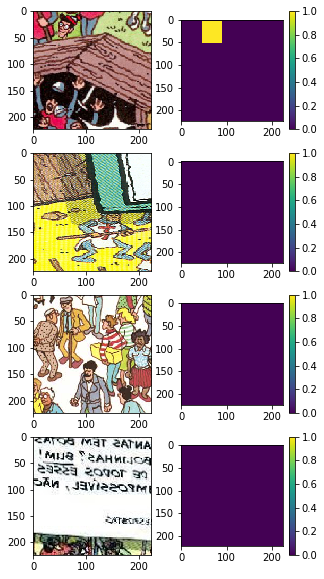

In [5]:
gen_mix = seg_gen_mix(waldo_sub_imgs, waldo_sub_labels, imgs, labels, tot_bs=4, prop=0.34, out_sz=(PANNEL_SIZE, PANNEL_SIZE))

X, y = next(gen_mix)

plt.figure(figsize=(5, 10))
for i, img in enumerate(X):
    plt.subplot(X.shape[0], 2, 2*i+1)
    plt.imshow(X[i])
    plt.subplot(X.shape[0], 2, 2*i+2)
    plt.colorbar()
    plt.imshow(y[i][:,1].reshape((PANNEL_SIZE, PANNEL_SIZE)))

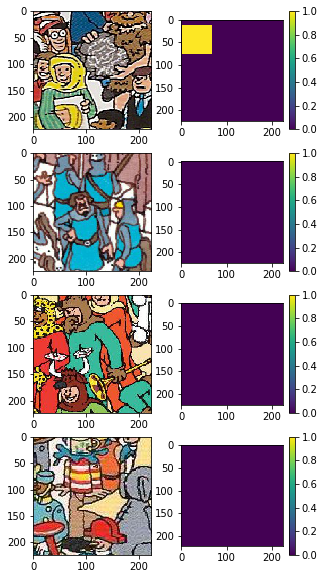

In [6]:
# waldo : not_waldo = 1 : 2 (0.34)
gen_mix = seg_gen_mix(waldo_sub_imgs, waldo_sub_labels, imgs, labels, tot_bs=4, prop=0.34, out_sz=(PANNEL_SIZE, PANNEL_SIZE))

X, y = next(gen_mix)

plt.figure(figsize=(5, 10))
for i, img in enumerate(X):
    plt.subplot(X.shape[0], 2, 2*i+1)
    plt.imshow(X[i])
    plt.subplot(X.shape[0], 2, 2*i+2)
    plt.colorbar()
    plt.imshow(y[i][:,1].reshape((PANNEL_SIZE, PANNEL_SIZE)))

88666846 37154


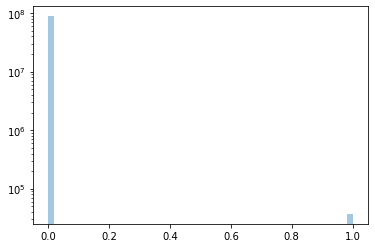

In [7]:
freq0 = np.sum(labels==0)
freq1 = np.sum(labels==1)

print(freq0, freq1)

sns.distplot(labels.flatten(), kde=False, hist_kws={'log':True})

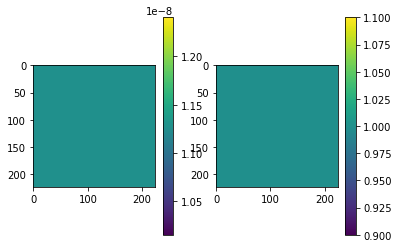

In [8]:
sample_weights = np.zeros((6, PANNEL_SIZE * PANNEL_SIZE, 2))

sample_weights[:,:,0] = 1. / freq0
sample_weights[:,:,1] = 1.

plt.subplot(1,2,1)
plt.imshow(sample_weights[0,:,0].reshape((224, 224)))
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(sample_weights[0,:,1].reshape((224, 224)))
plt.colorbar()

In [10]:
inputs = layers.Input(shape=(PANNEL_SIZE, PANNEL_SIZE, 3))

net = layers.Conv2D(64, kernel_size=3, padding='same')(inputs)
# net = layers.Activation('relu')(net)
net = layers.LeakyReLU()(net)
net = layers.MaxPool2D(pool_size=2)(net)

shortcut_1 = net

net = layers.Conv2D(128, kernel_size=3, padding='same')(net)
# net = layers.Activation('relu')(net)
net = layers.LeakyReLU()(net)
net = layers.MaxPool2D(pool_size=2)(net)

shortcut_2 = net

net = layers.Conv2D(256, kernel_size=3, padding='same')(net)
# net = layers.Activation('relu')(net)
net = layers.LeakyReLU()(net)
net = layers.MaxPool2D(pool_size=2)(net)

shortcut_3 = net

net = layers.Conv2D(256, kernel_size=1, padding='same')(net)
# net = layers.Activation('relu')(net)
net = layers.LeakyReLU()(net)
net = layers.MaxPool2D(pool_size=2)(net)

net = layers.UpSampling2D(size=2)(net)
net = layers.Conv2D(256, kernel_size=3, padding='same')(net)
net = layers.Activation('relu')(net)

net = layers.Add()([net, shortcut_3])

net = layers.UpSampling2D(size=2)(net)
net = layers.Conv2D(128, kernel_size=3, padding='same')(net)
net = layers.Activation('relu')(net)

net = layers.Add()([net, shortcut_2])

net = layers.UpSampling2D(size=2)(net)
net = layers.Conv2D(64, kernel_size=3, padding='same')(net)
net = layers.Activation('relu')(net)

net = layers.Add()([net, shortcut_1])

net = layers.UpSampling2D(size=2)(net)
net = layers.Conv2D(2, kernel_size=1, padding='same')(net)

net = layers.Reshape((-1, 2))(net)
net = layers.Activation('softmax')(net)

model = Model(inputs=inputs, outputs=net)

model.compile(
    loss='categorical_crossentropy', 
    optimizer=optimizers.Adam(), 
    metrics=['acc'], 
    sample_weight_mode='temporal'
)

model.summary()



Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 224, 224, 64) 1792        input_2[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_5 (LeakyReLU)       (None, 224, 224, 64) 0           conv2d_9[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_5 (MaxPooling2D)  (None, 112, 112, 64) 0           leaky_re_lu_5[0][0]              
____________________________________________________________________________________________

In [ ]:
gen_mix = seg_gen_mix(waldo_sub_imgs, waldo_sub_labels, imgs, labels, tot_bs=6, prop=0.34, out_sz=(PANNEL_SIZE, PANNEL_SIZE))

def on_epoch_end(epoch, logs):
    print('\r', 'Epoch:%5d - loss: %.4f - acc: %.4f' % (epoch, logs['loss'], logs['acc']), end='')

print_callback = LambdaCallback(on_epoch_end=on_epoch_end)

history = model.fit_generator(
    gen_mix, steps_per_epoch=6, epochs=500, 
    class_weight=sample_weights,
    verbose=0,
    callbacks=[
        print_callback,
        ReduceLROnPlateau(monitor='loss', factor=0.2, patience=100, verbose=1, mode='auto', min_lr=1e-05)
    ]
)

model.save('model.h5')

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.title('loss')
plt.plot(history.history['loss'])
plt.subplot(1, 2, 2)
plt.title('accuracy')
plt.plot(history.history['acc'])

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
 Epoch:  159 - loss: 0.0384 - acc: 0.9885

In [ ]:
img_filename = '02.jpg'
test_img = np.array(Image.open(os.path.join('test_imgs', img_filename)).resize((2800, 1760), Image.NEAREST)).astype(np.float32) / 255.

plt.figure(figsize=(20, 10))
plt.imshow(test_img)